# Predictive Power of FOMC statements on VIX



# Introduction

In this notebook, we have the following goal: find alpha in statements of FOMC meetings in relation to the VIX index. This will be achieved by using both algorithms seen in class and litterature on the subject.
-how vix is traded
-seasonnal effects of vix (mondays/fridays)...
-other economic statements

# Package Import

Firstly, we look to import the skfin which will be useful for all sort of things, as well as the different other libraries.

In [1]:
!git clone https://github.com/schampon/skfin.git
%cd skfin
!./create_env.sh

Cloning into 'skfin'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 303 (delta 19), reused 28 (delta 12), pack-reused 255
Receiving objects: 100% (303/303), 72.96 MiB | 29.15 MiB/s, done.
Resolving deltas: 100% (118/118), done.
/content/skfin
./create_env.sh: line 1: conda: command not found
./create_env.sh: line 2: conda: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 28

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import date
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from skfin.plot import bar, line
from tqdm.auto import tqdm
import yfinance as yf
from collections import Counter
from sklearn.linear_model import LogisticRegression

from skfin.datasets import load_fomc_statements, load_loughran_mcdonald_dictionary
from skfin.plot import line
from skfin.text import coefs_plot, show_text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pandas.tseries.offsets import BDay
from skfin.datasets import load_kf_returns
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline

from skfin.datasets import load_fomc_change_date
import matplotlib.cm as cm
from sklearn.decomposition import NMF, PCA

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.svm import SVR


from functools import reduce
import seaborn as sns

# Data Overview

For this project, we elect to use the Loughran-Mcdonald dictionary in a first instance to measure the overall sentiment of FOMC statements. Furthermore, we obtain the actual statements from the datasets comprised in skfin. Finally, the actual VIX close index values are retrieved from Yahoo Finance through the yfinance module.

In [3]:
statements = load_fomc_statements()
lm = load_loughran_mcdonald_dictionary()


As mentionned in the introduction, the litterature cites a significantly different impact of unannonced FOMC meeting compared to expected ones. By its very nature, the VIX index is heavely dependant on market conditions (...?) and thus our study of the impact of FOMC meetings would benefit greatly from excluding unscheduled meetings from our dataset as these mostly appear in extraordianry circumstances. These could potentially hold a lot of alpha in terms of vocabulary used as...(continue).

In [4]:
Counter([x.year for x in statements.index])

Counter({1999: 6,
         2000: 8,
         2001: 11,
         2002: 8,
         2003: 8,
         2004: 8,
         2005: 8,
         2006: 8,
         2007: 10,
         2008: 11,
         2009: 8,
         2010: 9,
         2011: 8,
         2012: 8,
         2013: 8,
         2014: 8,
         2015: 8,
         2016: 8,
         2017: 8,
         2018: 8,
         2019: 9,
         2020: 12,
         2021: 8,
         2022: 8,
         2023: 8,
         2024: 1})

We only consider these dates to be excluded as...

In [5]:
# Removing special days
print(len(statements.index))
special_days = ["2008-01-22", "2010-05-09", "2020-03-15"]
idx0 = pd.to_datetime(pd.Index(special_days))
idx = statements.index.difference(idx0)
statements = statements.loc[idx]
print(len(statements.index))

213
210


As for our target feature, we use VIX index data from yfinance. dates of interest...

In [6]:
vix_ticker = "^VIX"

start_date = "1999-01-01"
end_date = "2024-02-01"

vix_data = yf.download(vix_ticker, start=start_date, end=end_date)

vix_returns=pd.DataFrame(vix_data['Close'].pct_change()[1:])

[*********************100%***********************]  1 of 1 completed


#Initial analysis of the problem

Overview of the VIX index

<ipython-input-7-29adb778e500>:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o:r" (-> marker='o'). The keyword argument will take precedence.
  axs[2].plot(vix_data["Close"].loc[idx_end.strftime('%Y-%m-%d')], 'o:r', marker="*", ms=5)


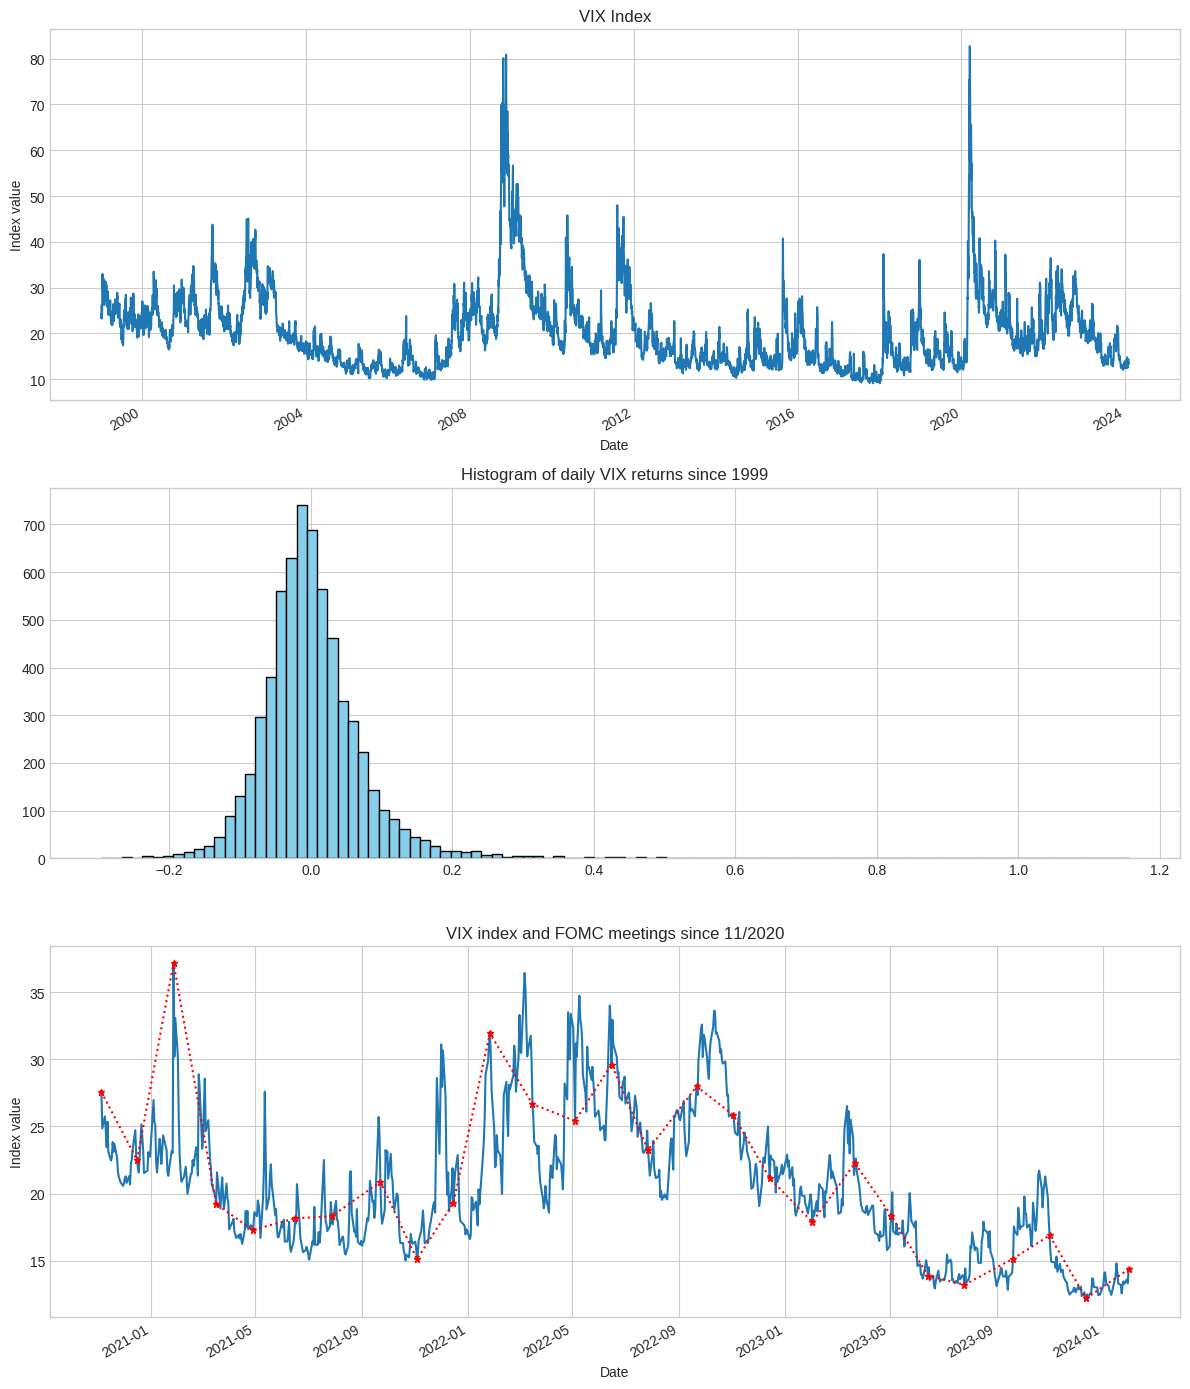

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(12, 14))

vix_data["Close"].plot(title="VIX Index", ylabel="Index value", xlabel="Date", ax=axs[0])

axs[1].hist(np.clip(vix_returns['Close'], -5, 5), color='skyblue', bins = 100, edgecolor='black')
axs[1].set_title('Histogram of daily VIX returns since 1999')

vix_data["Close"][5497:].plot(title="VIX Index", ylabel="Index value", xlabel="Date", ax=axs[2])
idx_end = idx[183:]
axs[2].plot(vix_data["Close"].loc[idx_end.strftime('%Y-%m-%d')], 'o:r', marker="*", ms=5)
axs[2].set_title('VIX index and FOMC meetings since 11/2020')

plt.tight_layout()
plt.show()

Whaley (2008) explains that the VIX historically follows mean-reverting tendencies, which is not disproved by the overall flat forward of the index, and the profil of its returns : slightly skewed negatively but with a fatter tail on the positive side. Phrase graphe 3-> extremum local mais pas tt le temps...

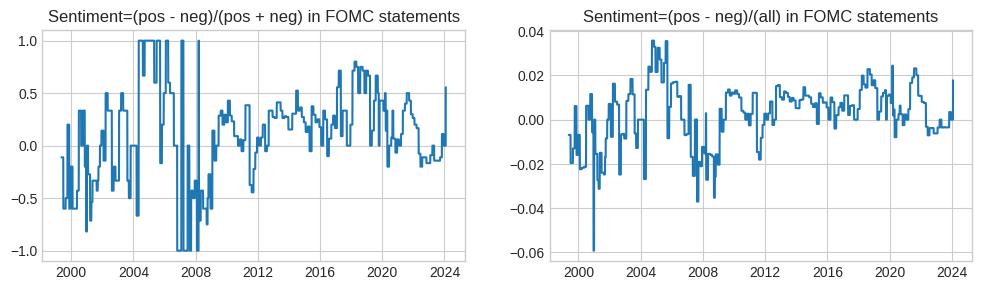

In [8]:
# First analysis
# Find the negative and positive words in the statements

X = statements["text"]

funcs = {
    "negative": lambda x: x.Negative > 0,
    "positive": lambda x: x.Positive > 0,
    "all": lambda x: x.Word.notna(),
}

def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)

lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()}, axis=1)

# This cell will show the negative (red) and positive (green) words in each statement
# and will plot the evolution of the sentiment in the FOMC statements throughout the years

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(pos + neg) in FOMC statements",
    ax=axs[0]
)

line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(all) in FOMC statements",
    ax=axs[1]
)

In [9]:
print((vix_returns['Close']).corr(lm_counts.pipe(lambda x: (x.positive - x.negative) / x["all"])))
print((vix_returns['Close']).corr(lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))))

0.04553717105514023
0.04952287593923554


<Axes: >

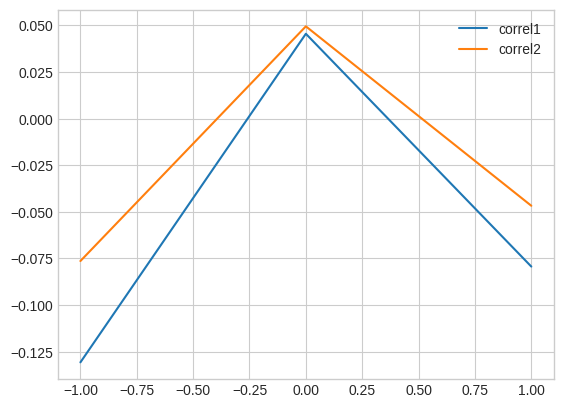

In [10]:
range_ = 1
sent1 = lm_counts.pipe(lambda x: (x.positive - x.negative) / x["all"])
sent2 = lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))
correl1 = []
correl2 = []

lags = [i for i in range(-range_, range_+1)]
for lag in lags:
  correl1.append((vix_returns['Close'].shift(-lag)).corr(sent1))
  correl2.append((vix_returns['Close'].shift(-lag)).corr(sent2))

correl_vix_lag = pd.DataFrame({'correl1': correl1, 'correl2': correl2})
correl_vix_lag.index = lags

correl_vix_lag.plot()

phrase correl sentiments

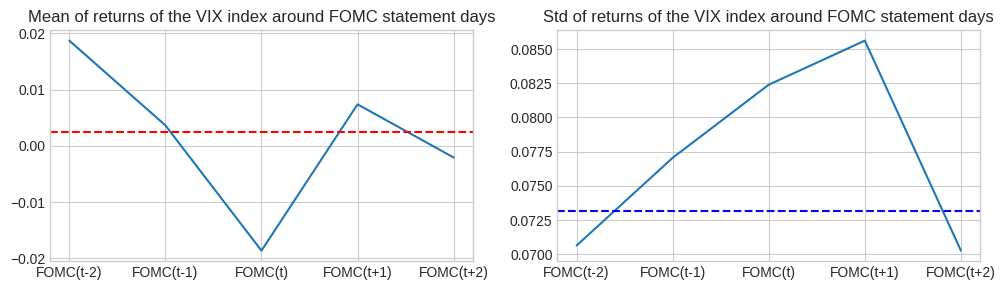

In [11]:
range_ = 2
lags = [i for i in range(-range_, range_+1)]
means = []
stds = []
for lag in lags:
  laged_index = statements.index + pd.tseries.offsets.BDay(lag)
  vix_laged = vix_returns.loc[laged_index.intersection(vix_returns.index)]
  mean = vix_laged.mean()['Close']
  std = vix_laged.std()['Close']
  stds.append(std)
  means.append(mean)


stats_vix_lag = pd.DataFrame({'means': means, 'stds': stds})
stats_vix_lag.index = lags

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

stats_vix_lag['means'].plot(ax=axs[0])
axs[0].axhline(y=vix_returns.mean()['Close'], color='r', linestyle='--',
               label=f'Horizontal Line at {np.round(vix_returns.mean()["Close"], 5)}')
axs[0].set_xticks(lags)
axs[0].set_xticklabels(["FOMC(t-2)", "FOMC(t-1)", "FOMC(t)", "FOMC(t+1)", "FOMC(t+2)"])
axs[0].set_title('Mean of returns of the VIX index around FOMC statement days')

stats_vix_lag['stds'].plot(ax=axs[1])
axs[1].axhline(y=vix_returns.std()['Close'], color='b', linestyle='--',
               label=f'Horizontal Line at {np.round(vix_returns.std()["Close"], 5)}')
axs[1].set_xticks(lags)
axs[1].set_xticklabels(["FOMC(t-2)", "FOMC(t-1)", "FOMC(t)", "FOMC(t+1)", "FOMC(t+2)"])
axs[1].set_title('Std of returns of the VIX index around FOMC statement days')

plt.show()

In the figure above, on the leftmost graph, we can see that VIX returns are indeed negative on FOMC meeting days, significantly lower than the average return across the whole period (represented by the red-dotted line). This validates what was supposed in the introduction: by representing the VIX as the index of uncertainty, on average, a FOMC decision concerning Fed Fund rates brings clarity to investors about the upcoming market, thus bringing the VIX down. It also confirms the U-shape around statements as the returns are on average higher than the mean both before and after the meeting. From the second graph, we can gather that VIX is itself more volatile around FOMC dates, as the standard deviations of the returns are more important around and at FOMC meeting dates (the standard deviation of the whole series is represented by the blue-dotted line). This is very important for our strategy: firstly, this indicates that there could be non-negligable alpha in our study; secondly, this std is at its highest for t+1 returns. Market participants usually react almost instantly to the statements (30 minute window). Intraday data of this sort isn't available to us at this time, only close quotes. Furthermore, if we were to put such a strategy into place, positions taken on the basis of FOMC statement analysis could only be made after the statements. As such, we really are interested in t+1 returns after analysis of FOMC statement at date t. This means that, even though we can't take part in the immediate movement of VIX following the statements, we can still appreciate some mean-reverting on the following day.

more downs than ups : a succeful strategy is likely to feature this property

# Implementing our strategy

The baseline strategy is very similar to the one seen in the lectures (chapter 19). After normalizing the returns series, we will try supervised learning by using pipelines comprised of the Tfidfectorizer method and some machine learning algorithm (a few are used here).

The TFIDF score enables us to record impactful words of each statements in the context of the entire corpus of statements. We then use the ML algorithm to match the text of each statement to VIX returns. As expressed earlier, the returns on the actual day of the meetings is not the most relevant as it would not be tradable, so we will shift our focus on the returns days after the actual statements: t+1, t+2, t+3... (which should still be relevant if we believe the previous figure).

In this section, we try 2 sorts of strategies: one where we simply predict the sign of the returns (if above 0.05 in absolute value). Thus, our Pnl series is simply : sign_predicted * r_real_(t+1). From there, we can calculate a Sharpe ratio.

The other type of strategy is to rather try to predict the return of the VIX index directly, not just the sign. For this strategy, how much to invest on a given day can be done a multiple of ways. Maybe naively, we chose to invest proportionally to what we predict, as to be very long if we predict big returns and very short in the opposed scenario. The Pnl series becomes: r_predicted_(t+1) * r_real_(t+1).

The following code enacts these strategies (model_binary, model_continuous) for multiple sorts of ML algorithms (ElasticNet, RandomForest, Gradient Boosting Regressor, Support Vector Regression, Gradient Boosting Classifier), simply to compare different methods, as well as for returns shifted for different horizons.

Every time, we will split 80% of our dataset into a train set and the rest in a test set in order to compute a Sharpe ratio. We will come back on this later.

In [66]:

def compute_lagged_return(vix_data,lag):
  """

  gives the lagged returns of the VIX in output.
  For instance, if lag = 1 then, it will give in output the returns of the next day after each statement release
  """
  vix_returns=pd.DataFrame(vix_data['Close'].pct_change()[1:]).shift(-lag)
  special_days = ["2008-01-22", "2010-05-09", "2020-03-15"]
  idx0 = pd.to_datetime(pd.Index(special_days))
  idx = statements.index.difference(idx0)#.union(idx0 + BDay(1))
  ret_fomc = vix_returns.div(vix_returns.ewm(252).std()).loc[vix_returns.index.intersection(idx)]
  return ret_fomc

def run_model_continuous(statements,returns,model):
  """

  Predicts the returns with distinct NLP/ML models.

  """
  if model=='ElasticNet':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg",  ElasticNet(alpha=0.008))
    ])

  elif model=='RF':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", RandomForestRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='GBR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='SVR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", SVR())
    ])

  #returns=returns[(returns['Close'] < -0.05) | (returns['Close'] > 0.05)]
  y=returns["Close"].dropna()
  y_index=y.index
  statements_concerned=statements.loc[statements.index.isin(y_index)]

  X=statements_concerned['text']
  y=y.loc[X.index]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

  est.fit(X_train, y_train)
  y_pred = est.predict(X_test)

  results=pd.DataFrame(y_test)
  results['pred']=y_pred

  return results


def run_model_binary(statements,returns,model):
  """

  Predicts the sign of the returns with distinct NLP/ML models.

  """
  if model=='ElasticNet':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg",  ElasticNet(alpha=0.008))
    ])

    # elif model=='LogReg':
    # est = Pipeline([
    #     ("tfidf", TfidfVectorizer(
    #         vocabulary=None,
    #         ngram_range=(1, 3),
    #         max_features=300,
    #         stop_words="english",
    #         token_pattern=r"\b[a-zA-Z]{3,}\b",
    #     )),
    #     ("reg", LogisticRegression(max_iter=5000))
    # ])

  elif model=='RF':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", RandomForestRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='GBR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='SVR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", SVR())
    ])

  elif model=='GBC':
      est = Pipeline([
          ("tfidf", TfidfVectorizer(
              vocabulary=None,
              ngram_range=(1, 3),
              max_features=300,
              stop_words="english",
              token_pattern=r"\b[a-zA-Z]{3,}\b",
          )),
          ("reg", GradientBoostingClassifier())
      ])


  returns=returns[(returns['Close'] < -0.005) | (returns['Close'] > 0.005)]
  y=np.sign(returns["Close"].dropna())
  y_index=y.index
  statements_concerned=statements.loc[statements.index.isin(y_index)]


  X=statements_concerned['text']
  y=y.loc[X.index]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
  est.fit(X_train, y_train)
  y_pred = est.predict(X_test)

  results=pd.DataFrame(y_test)
  results['pred']=np.sign(y_pred).astype(int)

  return accuracy_score(results['Close'],results['pred']),results

def compute_strategy(results,vix_data,lag):
  """

  Computes the induced strategy and the induces sharpe

  """
  data=pd.merge(results,vix_data['Close'],left_index=True,right_index=True)
  if lag !=0:
    data=pd.merge(data,vix_data['Close'].shift(-lag),left_index=True,right_index=True)
  else:
    data=pd.merge(data,vix_data['Close'].shift(1),left_index=True,right_index=True)

  data.columns=['Sign at t+'f'{lag}','Pred Sign at t+'+f'{lag}','Price at t','Price at t+'+f'{lag}']
  data['return at date t+'+f'{lag}']=(data['Price at t+'+f'{lag}']-data['Price at t'])/data['Price at t']
  if lag == 0:
    data['return at date t+'+f'{lag}']=(data['Price at t']-data['Price at t+'+f'{lag}'])/data['Price at t+'+f'{lag}']

  data['P&L']=data['Pred Sign at t+'+f'{lag}']*data['return at date t+'+f'{lag}']

  df_sharpe=pd.DataFrame(index=results.index)#index=range(5000)
  df_sharpe['P&L']=data['P&L']
  df_sharpe['P&L']=df_sharpe['P&L'].fillna(0)
  sharpe=np.sqrt(8)*df_sharpe['P&L'].mean()/(df_sharpe['P&L'].std()*np.sqrt(2))
  return data,sharpe

def pnl_graph(data):
  return data['P&L'].cumsum().plot()

# Main empirical results

In this section, we show results obtained by the aforementionned strategies as well as their limitations.

In [67]:
# We do it for each lag in [1,30]
models=['ElasticNet','RF','GBR','SVR','GBC']
dfs=[]
for model in models:
  print(model)
  data_binary=[]
  for i in range(3):
    ret_fomc=compute_lagged_return(vix_data,i)
    accuracy,results=run_model_binary(statements,ret_fomc,model)
    df,sharpe=compute_strategy(results,vix_data,i)
    data_binary.append([accuracy,sharpe])

    index=['t+'f'{i}' for i in range(3)]
  final_binary_result=pd.DataFrame(data_binary,columns=['accuracy_'+model,'sharpe_binary_'+model],index=index)
  dfs.append(final_binary_result)
merged_df = reduce(lambda left, right: pd.merge(left,right,left_index=True,right_index=True), dfs)
merged_df#.head()

ElasticNet
RF
GBR
SVR
GBC


,accuracy_ElasticNet,sharpe_binary_ElasticNet,accuracy_RF,sharpe_binary_RF,accuracy_GBR,sharpe_binary_GBR,accuracy_SVR,sharpe_binary_SVR,accuracy_GBC,sharpe_binary_GBC
t+0,0.595238,0.485290,0.452381,-0.038839,0.500000,0.183583,0.595238,0.558250,0.476190,0.177413
t+1,0.523810,0.037066,0.523810,-0.372699,0.571429,-0.200576,0.452381,-0.267776,0.571429,-0.199801
t+2,0.500000,-0.343109,0.428571,-0.312929,0.523810,-0.057479,0.380952,-0.281211,0.500000,-0.194762


The outcome of the sign predicting procedure is included in this table. For different lags around FOMC meetings, we show the accuracy and the Sharpe ratio obtained for each algorithm.

In [68]:
# We do it for each lag in [1,30]
models=['ElasticNet','RF','GBR','SVR']
index=['t+'f'{i}' for i in range(3)]
dfs_cont=[]
for model in models:
  data_continuous=[]
  for i in range(3):
    ret_fomc=compute_lagged_return(vix_data,i)
    results=run_model_continuous(statements,ret_fomc,model)
    df,sharpe=compute_strategy(results,vix_data,i)
    data_continuous.append(sharpe)
  final_continuous_result=pd.DataFrame(data_continuous,columns=['sharpe_continuous_'+model],index=index)
  dfs_cont.append(final_continuous_result)

merged_df_cont = reduce(lambda left, right: pd.merge(left,right,left_index=True,right_index=True), dfs_cont)
merged_df_cont.head()

,sharpe_continuous_ElasticNet,sharpe_continuous_RF,sharpe_continuous_GBR,sharpe_continuous_SVR
t+0,0.921163,-0.179178,-0.194349,0.660450
t+1,0.444540,0.023225,-0.099959,-0.147333
t+2,-0.535038,-0.715822,-0.449985,-0.462198


Similar table, but for the return predicting method. We plot these tables in the following cell.

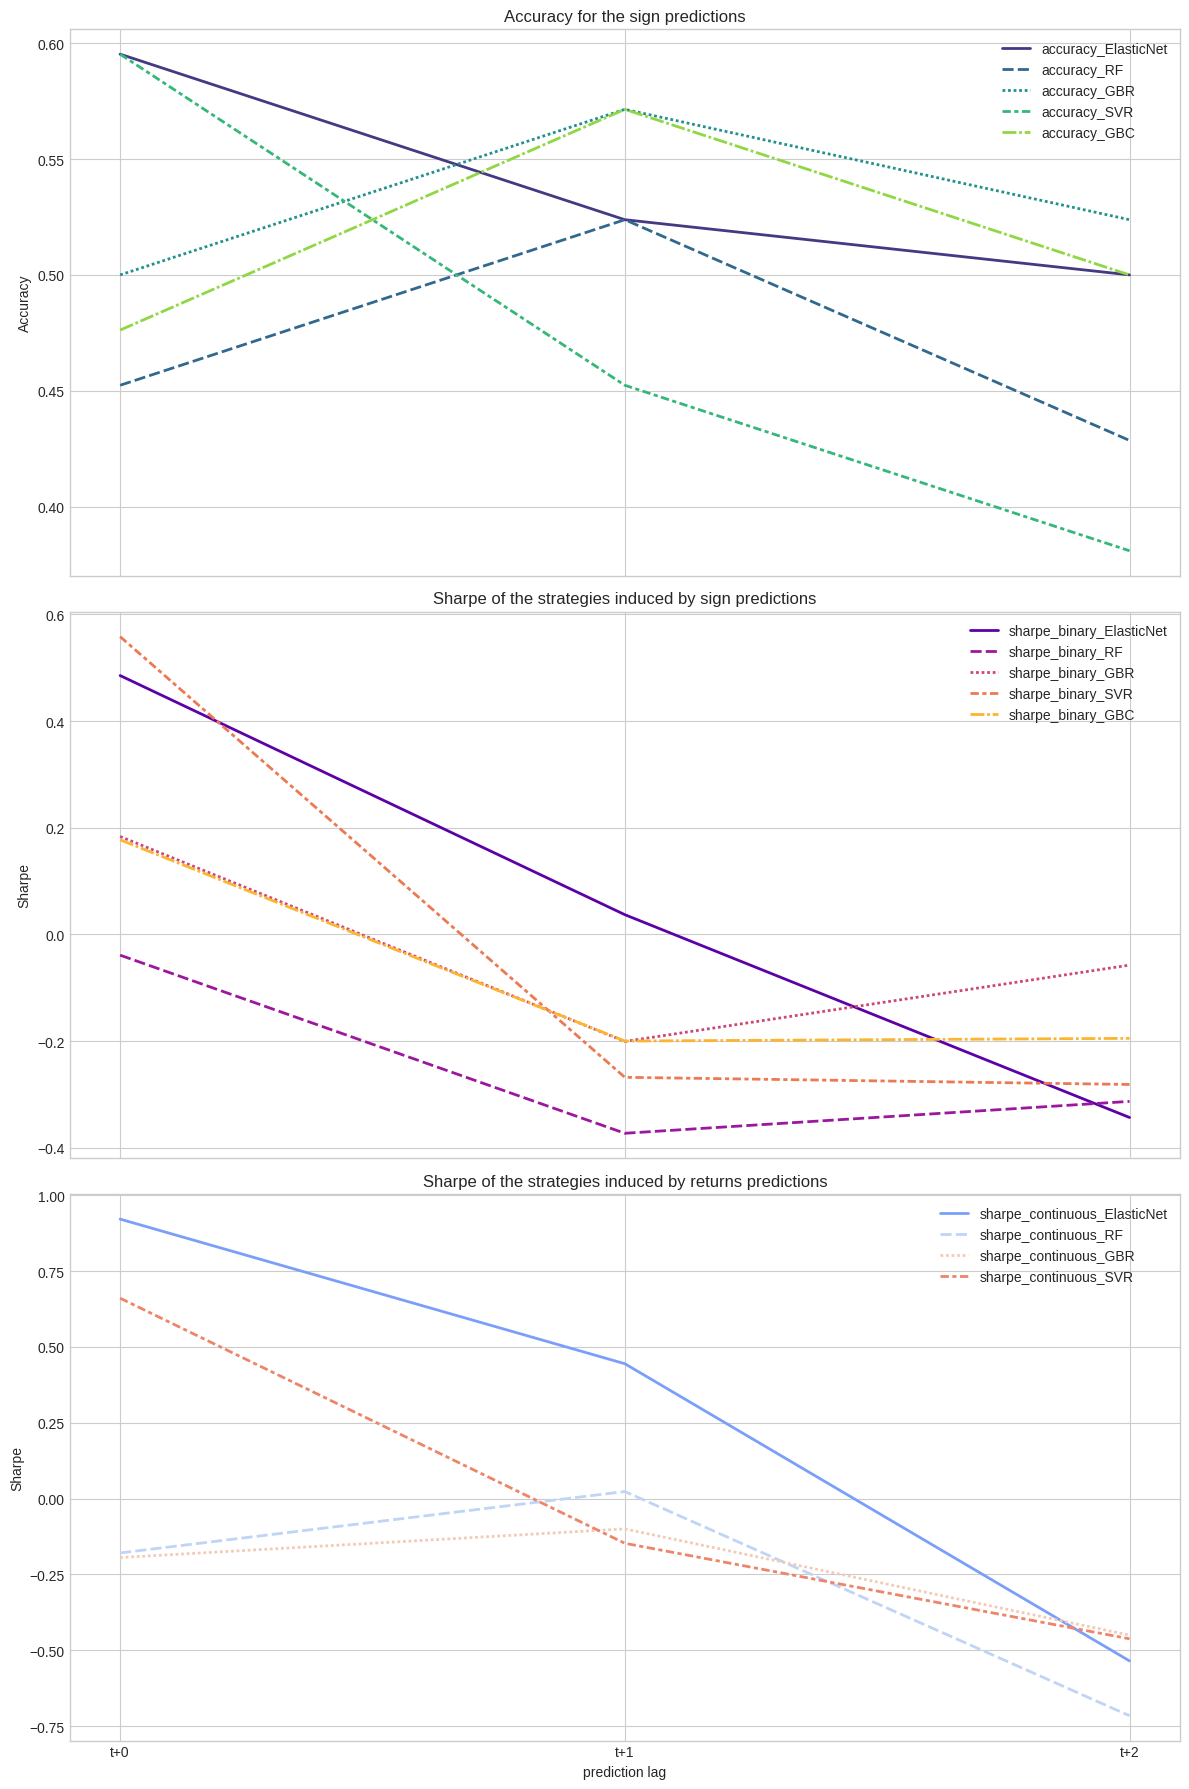

In [69]:
# This cells will plot the evolution of the accuracy (only for the sign prediction)
# and the sharpe induced by each NLP/Model predictions

accuracy_columns = [col for col in merged_df.columns if col.startswith("accuracy")]
sharpe_columns = [col for col in merged_df.columns if col.startswith("sharpe")]
sharpe_cont_columns = [col for col in merged_df_cont.columns if col.startswith("sharpe")]

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Plotting Accuracy columns
sns.lineplot(ax=axes[0], data=merged_df[accuracy_columns], palette="viridis", linewidth=2)
axes[0].set_title('Accuracy for the sign predictions')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('prediction lag')

# Plotting Sharpe columns
sns.lineplot(ax=axes[1], data=merged_df[sharpe_columns], palette="plasma", linewidth=2)
axes[1].set_title('Sharpe of the strategies induced by sign predictions')
axes[1].set_ylabel('Sharpe')
axes[1].set_xlabel('prediction lag')

# Plotting Sharpe continuous columns
sns.lineplot(ax=axes[2], data=merged_df_cont[sharpe_cont_columns], palette="coolwarm", linewidth=2)
axes[2].set_title('Sharpe of the strategies induced by returns predictions')
axes[2].set_ylabel('Sharpe')
axes[2].set_xlabel('prediction lag')

# Set common xlabel

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Our implementation has 2 fundamental problems. Firstly, we want to avoid forward information bias when computing the Pnl on the very dataset used to train the model. However, by spliting our already scarce dataset, we have on one hand less points to train the model, and most importantly on the other hand very few data points (about 30) to compute the Pnl series. Thus, our Sharpe ratios vary highly from one simulation to the other, and it is complicated to be confident in a particular strategy over another one.

The second problem we face is that our strategy only trades about 8 times per year, and only on daily returns (or 2 day spans returns for the t+2 prediction), which seems quite limited.

We analyse the following general trends: after running the simulations a few times, we see that t+0 returns tend to be more influenced by our NLP analysis, which makes sense as markets price in new information very rapidly. Overall, the Sharpe ratio tend to decrease with the lag on the prediction. The best Sharpe ratios obtained are thus for t+1 predictions, and generally come from the return predicting algorithms. Best ones are in the region of 0.5 and for the ElasticNet.

We will try to correct our first problem in the next cells, as for the second one, it cannot be alleviated by the very nature of our strategy. It could nonetheless be combined with a mean reverting strategy: for instance, if we predict a positive t+1 return, we could also add a short position the following day and vice versa.

### Convergence of the model


We compute 5-fold cross validation for the convergence of the model

In [92]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=5)
returns=compute_lagged_return(vix_data,1)

est = Pipeline([
    ("tfidf", TfidfVectorizer(
        vocabulary=None,
        ngram_range=(1, 3),
        max_features=300,
        stop_words="english",
        token_pattern=r"\b[a-zA-Z]{3,}\b",
    )),
    ("reg",  ElasticNet(alpha=0.008))
])






#returns=returns[(returns['Close'] < -0.05) | (returns['Close'] > 0.05)]
y=returns["Close"].dropna()
y_index=y.index
statements_concerned=statements.loc[statements.index.isin(y_index)]


X=statements_concerned['text']
y=y.loc[X.index]




result=[]
vocab_coef = pd.DataFrame()
for train_index, test_index in skf.split(X, y):
  X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
  est.fit(X_train, y_train)
  vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index
  interpret_coef = pd.DataFrame(np.transpose(est.named_steps["reg"].coef_), index=vocab_)
  vocab_coef = pd.concat([vocab_coef, interpret_coef])

  y_pred = est.predict(X_test)
  results=pd.DataFrame(y_test)
  results['pred']=y_pred
  result.append(results)


vocab_coef.groupby(vocab_coef.index).sum()/5

lag=1
final_results=pd.concat(result)
data=pd.merge(final_results,vix_data['Close'],left_index=True,right_index=True)
data=pd.merge(data,vix_data['Close'].shift(-lag),left_index=True,right_index=True)

data.columns=['Sign at t+'f'{lag}','Pred Sign at t+'+f'{lag}','Price at t','Price at t+'+f'{lag}']
data['return at date t+'+f'{lag}']=(data['Price at t+'+f'{lag}']-data['Price at t'])/data['Price at t']

data['P&L']=data['Pred Sign at t+'+f'{lag}']*data['return at date t+'+f'{lag}']

df_sharpe=pd.DataFrame(index=y.index)#index=range(5000)
#df_sharpe['P&L']=data.reset_index(drop=True)['P&L']
df_sharpe['P&L']=data['P&L']
df_sharpe['P&L']=df_sharpe['P&L'].fillna(0)
sharpe=np.sqrt(8/lag)*df_sharpe['P&L'].mean()/(df_sharpe['P&L'].std()*np.sqrt(2))
print(sharpe)


0.32174010519256424


<Axes: >

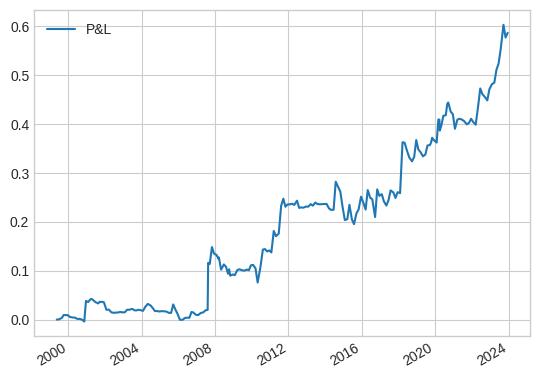

In [93]:
data[['P&L']].cumsum().plot()

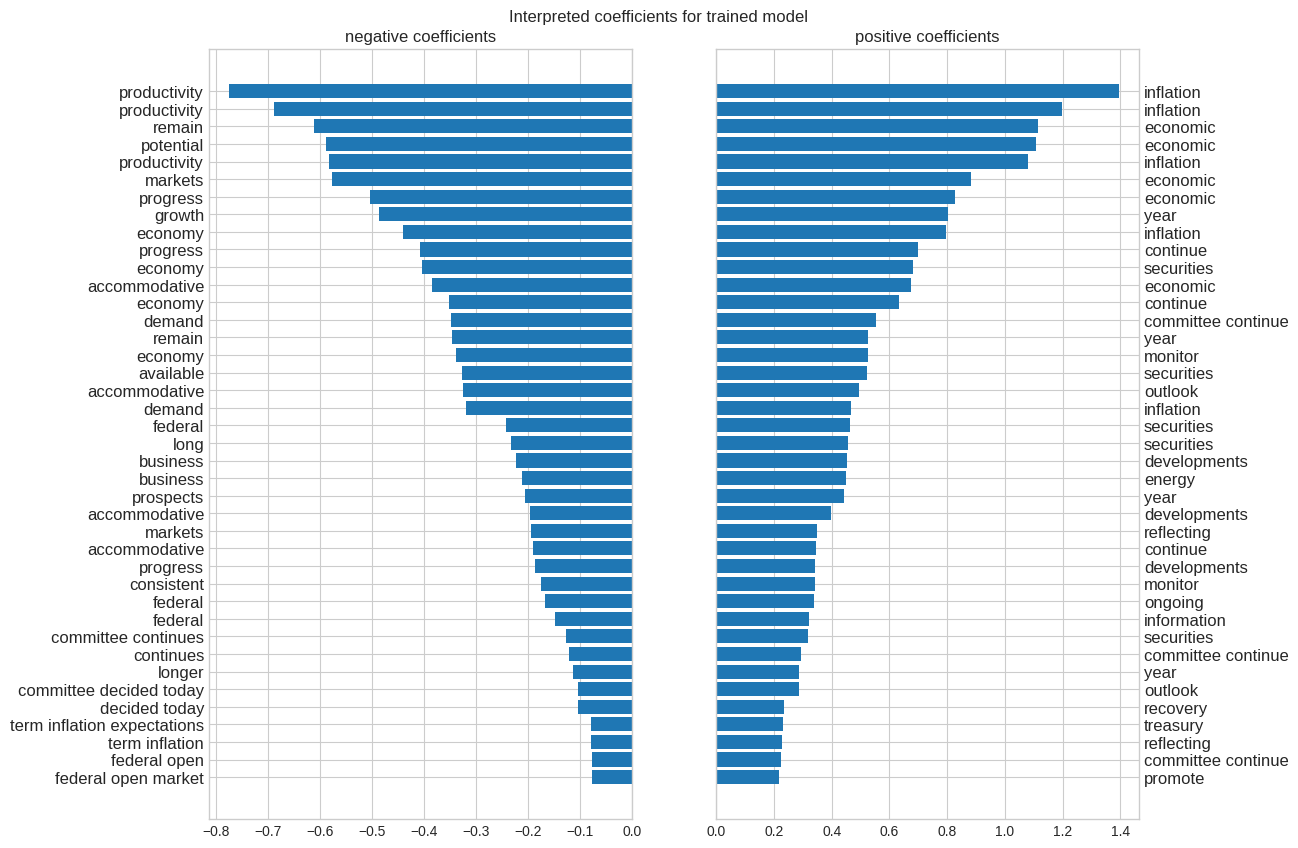

In [91]:
coefs_plot(vocab_coef, title="Interpreted coefficients for trained model")

In [146]:
from skfin.datasets import load_fomc_change_date
fomc_change_up, fomc_change_dw = load_fomc_change_date()

other = {
    "other_dt_change": ["2003-01-09", "2008-03-16", "2011-06-22"],
    "statements_dt_change_other": ["2007-08-16"],
    "qe1": ["2008-11-25", "2008-12-01", "2008-12-16", "2009-03-18"],
    "qe2": ["2010-11-03"],
    "twist": ["2011-09-21", "2012-06-20"],
    "qe3": ["2012-09-13", "2012-12-12", "2013-12-13"],
    "corona": ["2020-03-20"],
}

dates = {
    "up": fomc_change_up,
    "dw": fomc_change_dw,
    "other": [pd.Timestamp(d) for c in other.values() for d in c],
}
dates["no change"] = statements.index.difference([d for c in dates.values() for d in c])

In [148]:
df = pd.DataFrame()
for change in dates:
  change_list = []
  for date in dates[change]:
    if date in vix_returns.index:
      change_list.append(vix_returns.loc[date]['Close'])
  change_df = pd.DataFrame(change_list, index = [a for a in dates[change] if a in vix_returns.index], columns = [change])
  df = pd.concat([df, change_df])

print(df.mean())
print(df.std())

up          -0.031388
dw           0.001123
other       -0.010878
no change   -0.017992
dtype: float64
up           0.056905
dw           0.112059
other        0.095722
no change    0.082222
dtype: float64


In [149]:
rate_changes = pd.DataFrame(columns = ['Change'])
for change in dates:
  signe = 0
  if change == 'up':
    signe = 1
  elif change == 'dw':
    signe = -1
  for date in dates[change]:
    rate_changes.loc[date] = signe
rate_changes = rate_changes.sort_index()

<Axes: >

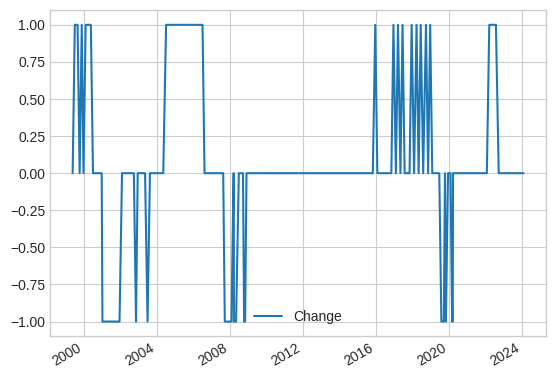

In [150]:
rate_changes.plot()

-0.11032843558798007

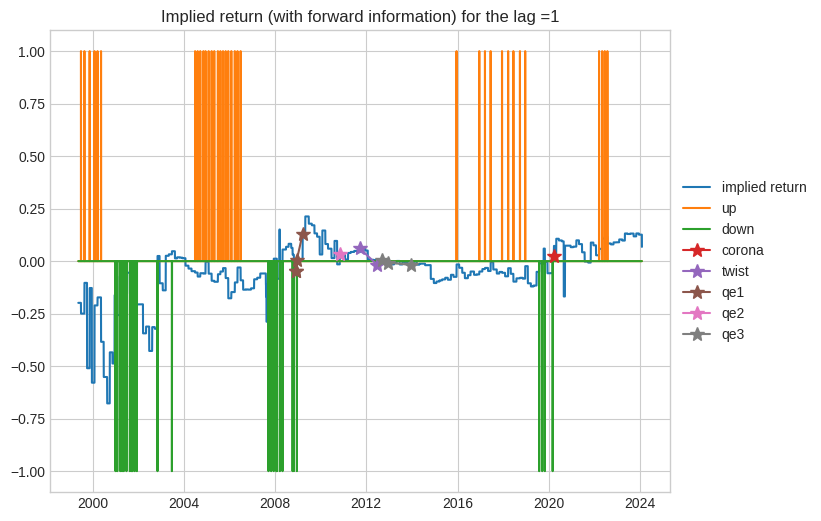

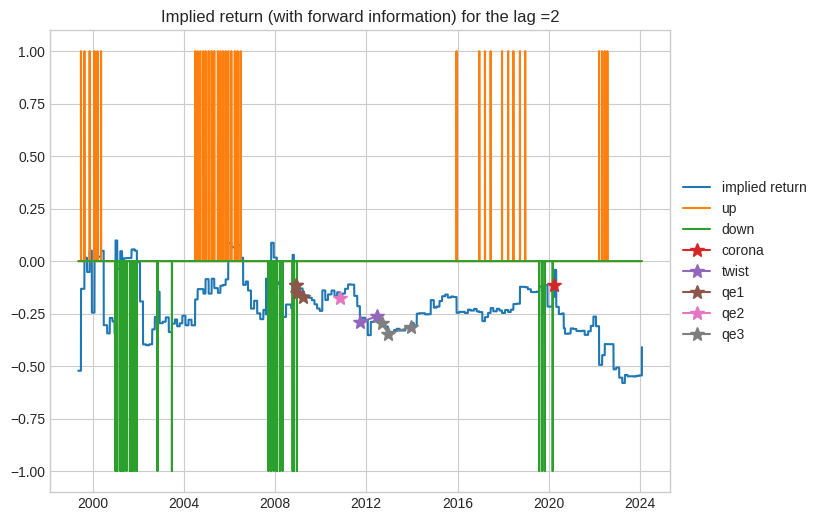

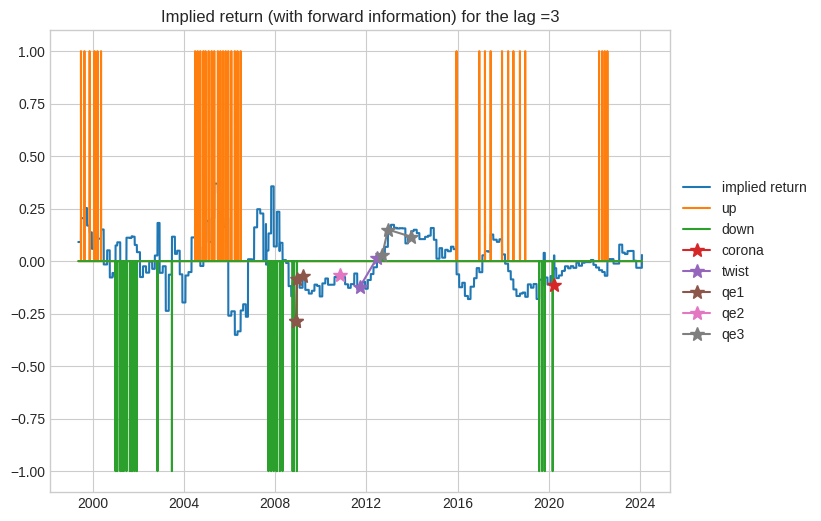

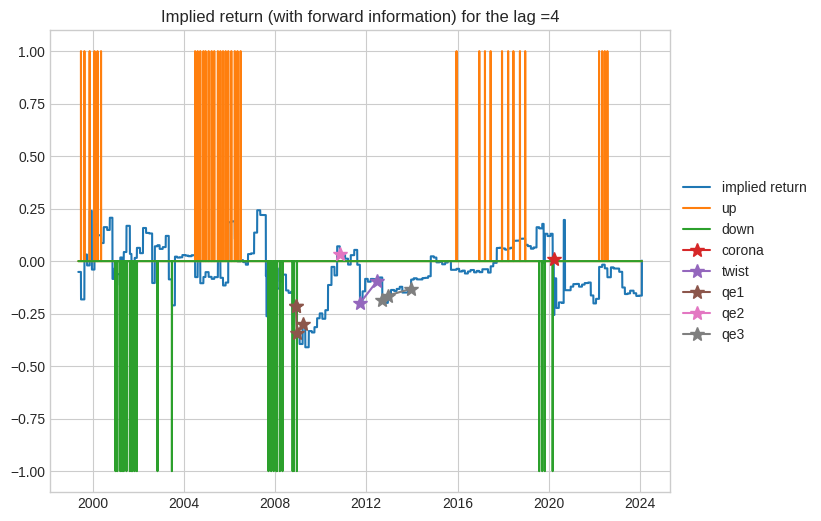

In [ ]:
def plot_coeff(statements,returns,lag):
  est = Pipeline([
      ("tfidf", TfidfVectorizer(
          vocabulary=None,
          ngram_range=(1, 3),
          max_features=500,
          stop_words="english",
          token_pattern=r"\b[a-zA-Z]{3,}\b",
      )),
      ("reg",  ElasticNet(alpha=0.0075))
  ])

  returns=returns[(returns['Close'] < -0.05) | (returns['Close'] > 0.05)]
  y=np.sign(returns["Close"].dropna())
  y_index=y.index
  statements_concerned=statements.loc[statements.index.isin(y_index)]


  X=statements_concerned['text']
  y=y.loc[X.index]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  est.fit(X_train, y_train)

  fig, ax = plt.subplots(figsize=(8, 6))
  pred_tfidf = (
      pd.Series(est.predict(statements["text"]), index=statements.index)
      .resample("B")
      .last()
      .ffill()
  )
  line(
      pred_tfidf.rename("implied rate")
      .to_frame()
      .join(
          pd.Series(1, index=fomc_change_up)
          .reindex(pred_tfidf.index)
          .fillna(0)
          .rename("up")
  ) .join(
          pd.Series(-1, index=fomc_change_dw)
          .reindex(pred_tfidf.index)
          .fillna(0)
          .rename("dw")
      ),
      sort=False,
      ax=ax,
      title="Implied return (with forward information) for the lag ="+f'{lag}',
  )
  cols = ["corona", "twist", "qe1", "qe2", "qe3"]
  for c in cols:
      ax.plot(pred_tfidf.loc[other[c]], marker="*", ms=10)
  ax.legend(
      ["implied return", "up", "down"] + cols, loc="center left", bbox_to_anchor=(1, 0.5)
  )

# VIZUALISATION FOR THE 5 day ahead
for i in range(1,5):
  ret_fomc=compute_lagged_return(vix_data,i)
  plot_coeff(statements,ret_fomc,i)